In [1]:
# import libraries 
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

In [18]:
# Set of functions



def get_dynamics(graph, params, plot=False):
    """
    Function to get the dynamics of the graph
    """
    # Parameters
    alpha = params['alpha']
    beta = params['beta']
    delta = params['delta']
    do = params['do']
    I = params['I']
    rho_ss = params['rho_ss']
    O_ss = params['O_ss']
    lambda_c = params['lambda_c']
    G = graph
    n = len(G.nodes())
    A = nx.adjacency_matrix(G).todense()

    
    def system(t, y, A, alpha, beta, delta, do, I):
        """
        y[k][0] is rho
        y[k][1] is O
        n repetitions for each municipality
        2 variables, rho and O
        """


        y = y.reshape(n, 2)
        
        dydt = np.zeros_like(y)

        

        def function_1(j):
            return A[i][j] * (y[j][0] - y[i][0])
        
        def function_2(j):
            return A[i][j] * ((y[i][1]/y[j][1])**I * y[j][0] - (y[j][1]/y[i][1])**I * y[i][0])
        
        def function_3(j):
            return A[i][j] * (y[j][1] - y[i][1])
        
        j = np.arange(16)
        

        for i in range(n):
            f_1_j = np.vectorize(function_1)(j)
            f_2_j = np.vectorize(function_2)(j)
            f_3_j = np.vectorize(function_3)(j)
            dydt[i, 0] = -y[i, 0] * y[i, 1] + alpha + np.sum(f_1_j) + np.sum(f_2_j)
            dydt[i, 1] = -delta * y[i, 1] + beta + y[i, 0] * y[i, 1] + do * np.sum(f_3_j)

        return dydt.flatten()
    # Initial conditions
    np.random.seed(0)
    y0 = np.random.uniform(0.01, 2, n * 2)

    # Time span
    t_span = (0, 1000)
    t_eval = np.linspace(*t_span, 1000)

    # Solve the system of ODEs
    print("Starting the integration...")
    solution = sp.integrate.solve_ivp(system, t_span, y0, args=(A, alpha, beta, delta, do, I), t_eval=t_eval)
    print("Integration finished.")

    t = solution.t
    y = solution.y.reshape(n, 2, -1)

    # Extract the stationary state from the dynamics (the last values)
    nodes = np.arange(1, n + 1)
    last_values_rho = np.zeros(n)
    last_values_O = np.zeros(n)
    for i in range(n):
        last_values_rho[i] = y[i, 0][-1]
        last_values_O[i] = y[i, 1][-1]

    print("Linear algebra computations...")
    # Computing the spectrum of the Laplacian matrix
    L = -1 * nx.laplacian_matrix(G).todense()

    eigenvalues, eigenvectors = np.linalg.eig(L)

    # get the index of the nearest eigenvalue to lambda_c
    index_lambda_c = np.argmin(np.abs(eigenvalues - lambda_c))
    critical_eigenvector = eigenvectors[:, index_lambda_c]
    

    print("Finished computations.")

    if plot:
        
        # Creating the stem plots
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))

        axes[0].stem(nodes, last_values_rho, linefmt='gray', markerfmt='ko', basefmt=' ', bottom=rho_ss)
        axes[0].axhline(rho_ss, color='red', linestyle='--')


        # Labeling the axes
        axes[0].set_xlabel('Nodes')
        axes[0].set_ylabel('rho')

        axes[1].stem(nodes, last_values_O, linefmt='gray', markerfmt='ko', basefmt=' ', bottom=O_ss)
        axes[1].axhline(O_ss, color='red', linestyle='--')

        # Labeling the axes
        axes[1].set_xlabel('Nodes')
        axes[1].set_ylabel('O')

        axes[2].stem(nodes, critical_eigenvector, linefmt='gray', markerfmt='ko', basefmt=' ')
        axes[2].axhline(0, color='red', linestyle='--')

        # Labeling the axes
        axes[2].set_xlabel('Nodes')
        axes[2].set_ylabel('eigenvector')

        # Display the plot
        plt.show()

    # Variance 
    variance_rho = np.var(last_values_rho)
    variance_O = np.var(last_values_O)
    variance_eigenvector = np.var(critical_eigenvector)

    # Inverse Participation Ratio (IPR)
    ipr_rho = np.sum(last_values_rho**4) / (np.sum(last_values_rho**2)**2)
    ipr_O = np.sum(last_values_O**4) / (np.sum(last_values_O**2)**2)
    ipr_eigenvector = np.sum(critical_eigenvector**4) / (np.sum(critical_eigenvector**2)**2)




    # Return the results
    return {
        'critical_eigenvalue': eigenvalues[index_lambda_c],
        'last_values_rho': last_values_rho,
        'last_values_O': last_values_O,
        'critical_eigenvector': critical_eigenvector,
        'variance_rho': variance_rho,
        'variance_O': variance_O,
        'variance_eigenvector': variance_eigenvector,
        'ipr_rho': ipr_rho,
        'ipr_O': ipr_O,
        'ipr_eigenvector': ipr_eigenvector
    }
        


        


    

In [19]:
# Create an empty graph
G = nx.Graph()

# Add nodes
nodes = range(1, 17)
G.add_nodes_from(nodes)

# Add edges based on the visual structure
edges = [
    (1, 2), (1, 3), (1, 4), (2, 4), (2,5), (3, 4), (3, 6), (3, 7), (3, 8), (4, 5), (4, 8), (4, 9),
    (5, 9), (6, 7), (7, 8), (7, 11), (7, 10), (7, 13), (8, 9), (8, 11), (8, 12), (9, 12),
    (10, 13), (11, 12), (11, 13), (11, 14), (12, 14), (12, 15), (13, 14), (13, 16) ,(14, 15),
    (14, 16), (15, 16)
]
G.add_edges_from(edges)

# Set parameters
alpha = 0.0050415
beta = 0.000013047
delta = 0.0079639
do = 0.0017783
numerator = 2 * delta**2 * beta + do * (alpha + beta)**2 + 2 * (alpha + beta) * delta * np.sqrt(2 * do * (alpha + beta))
denominator = 2 * alpha * delta**2
Ic = numerator / denominator
I = Ic

# Critical eigenvalue, must be 1.19198455
lambda_c = (do * (alpha + beta)**2 + 2 * beta * delta**2 - 2 * I * alpha * delta**2) / (4 * do * delta * (alpha + beta))

# Compute the homogeneous steady states
rho_ss = alpha * delta / (alpha + beta)
O_ss = (alpha + beta) / delta
params = {
    'alpha': alpha,
    'beta': beta,
    'delta': delta,
    'do': do,
    'I': I,
    'rho_ss': rho_ss,
    'O_ss': O_ss,
    'lambda_c': lambda_c
}

In [20]:
params

{'alpha': 0.0050415,
 'beta': 1.3047e-05,
 'delta': 0.0079639,
 'do': 0.0017783,
 'I': np.float64(0.6074034423516578),
 'rho_ss': 0.007943343261028139,
 'O_ss': 0.6346823792363039,
 'lambda_c': np.float64(-1.1921299735869972)}

Starting the integration...
Integration finished.
Linear algebra computations...
Finished computations.


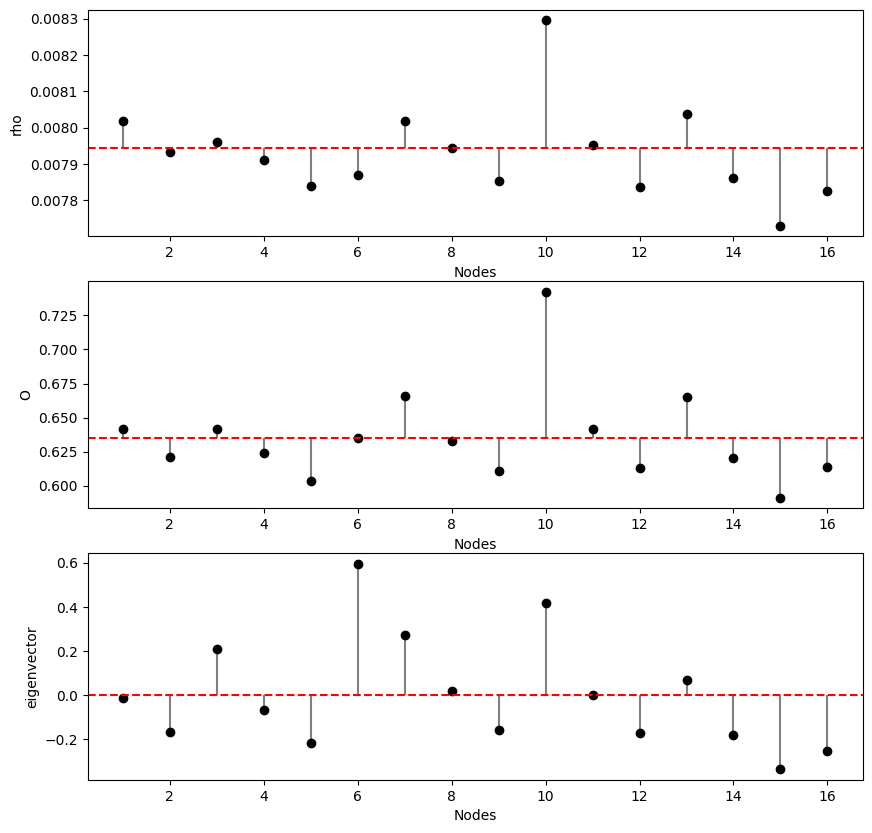

{'critical_eigenvalue': np.float64(-1.192131278815221),
 'last_values_rho': array([0.00801767, 0.00793351, 0.00796141, 0.00791043, 0.00783789,
        0.00786875, 0.00801754, 0.00794381, 0.0078537 , 0.00829608,
        0.00795209, 0.00783603, 0.00803712, 0.00786185, 0.00772913,
        0.0078239 ]),
 'last_values_O': array([0.64127094, 0.621348  , 0.64126669, 0.62410965, 0.60353245,
        0.63470996, 0.66571119, 0.63264641, 0.61069225, 0.7424042 ,
        0.64189769, 0.61323191, 0.66531719, 0.6206441 , 0.59113912,
        0.61367921]),
 'critical_eigenvector': array([-0.01413699, -0.16672971,  0.21017903, -0.06900715, -0.21828129,
         0.59604915,  0.27135043,  0.01607873, -0.15888706,  0.41765606,
        -0.00140655, -0.1749243 ,  0.06606083, -0.18392166, -0.33795222,
        -0.25212729]),
 'variance_rho': np.float64(1.537774866506758e-08),
 'variance_O': np.float64(0.0011545814284004048),
 'variance_eigenvector': np.float64(0.06249999999999999),
 'ipr_rho': np.float64(0.06256

In [21]:
get_dynamics(G, params, plot=True)